<a href="https://colab.research.google.com/github/zgbl/WeiqiBoardDetect/blob/main/notebooks/BoardDetect2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import matplotlib.font_manager as fm

In [2]:
# 加载图像
uploaded = files.upload()
img_path = list(uploaded.keys())[0]
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#img = cv2.imread("go_board.jpg")  # 换成你自己的图像路径
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

Saving Pic1.jpg to Pic1.jpg


In [3]:
# 边缘检测
blur = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(blur, 50, 150)

In [5]:
# 找轮廓
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [7]:
# 找最大的轮廓（假设是棋盘）
contour = max(contours, key=cv2.contourArea)

In [8]:
# 多边形逼近
epsilon = 0.02 * cv2.arcLength(contour, True)
approx = cv2.approxPolyDP(contour, epsilon, True)

In [10]:
# 提取四角点
print("approx is:", approx)
if len(approx) == 4:
    pts_src = approx.reshape(4, 2).astype("float32")

    # 排序：左上、右上、右下、左下
    def order_points(pts):
        rect = np.zeros((4, 2), dtype="float32")
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]
        return rect

    pts_src = order_points(pts_src)

    # 画出来确认
    for pt in pts_src:
        cv2.circle(image, tuple(pt.astype(int)), 10, (0, 0, 255), -1)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Detected Chessboard Corners")
    plt.axis("off")
    plt.show()

else:
    print("❌ 没有检测到恰好四个角点，请调整轮廓检测参数")

approx is: [[[ 17  14]]

 [[299  16]]

 [[ 71 190]]

 [[296 295]]

 [[194 123]]

 [[313 202]]

 [[299  15]]]
❌ 没有检测到恰好四个角点，请调整轮廓检测参数


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32418 (\N{CJK UNIFIED IDEOGRAPH-7EA2}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22280 (\N{CJK UNIFIED IDEOGRAPH-5708}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22352 (\N{CJK UNIFIED IDEOGRAPH-5750}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


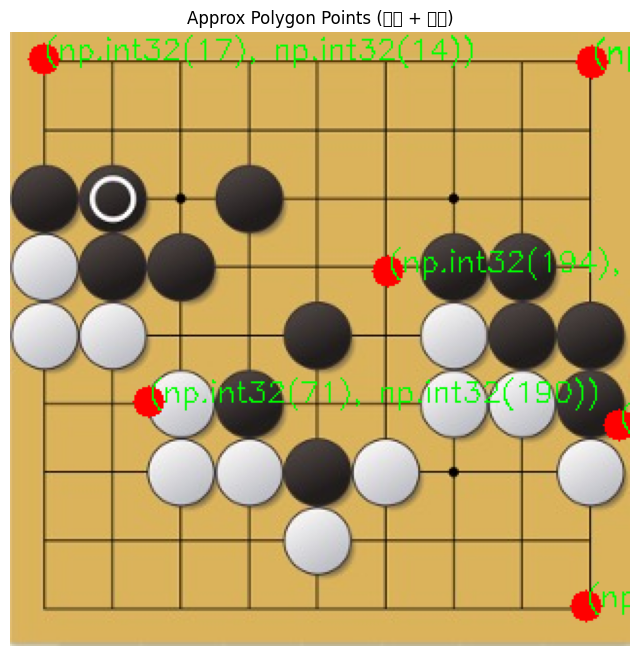

In [11]:
img_draw = img.copy()
for pt in approx:
    pt = tuple(pt[0])  # 取出坐标
    cv2.circle(img_draw, pt, 8, (0, 0, 255), -1)
    cv2.putText(img_draw, str(pt), pt, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB))
plt.title("Approx Polygon Points (红圈 + 坐标)")
plt.axis("off")
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 33258 (\N{CJK UNIFIED IDEOGRAPH-81EA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21160 (\N{CJK UNIFIED IDEOGRAPH-52A8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36873 (\N{CJK UNIFIED IDEOGRAPH-9009}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21462 (\N{CJK UNIFIED IDEOGRAPH-53D6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_fi

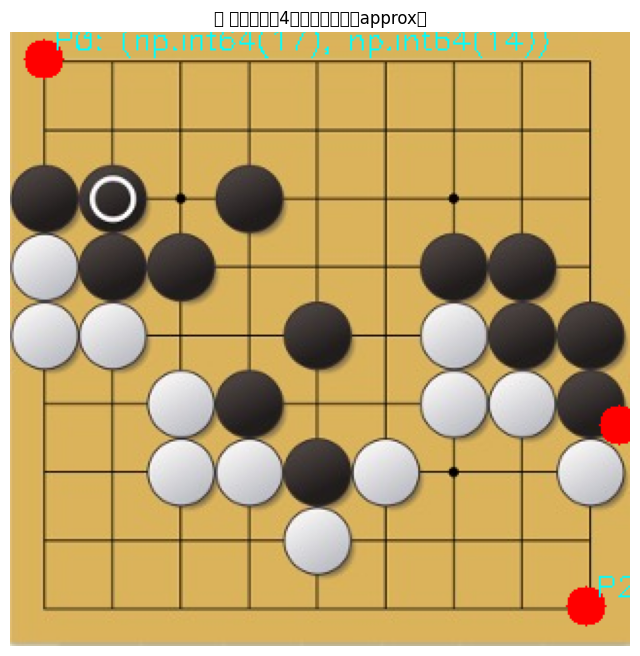

In [12]:
# 假设 approx 已经是从轮廓中提取出来的 N x 1 x 2 形状
pts = approx.reshape(-1, 2)  # 变为 N x 2 坐标列表

# 四个关键点（使用横坐标与和的极值来近似四角）
leftmost = pts[np.argmin(pts[:, 0])]
rightmost = pts[np.argmax(pts[:, 0])]
topleft = pts[np.argmin(pts.sum(axis=1))]
bottomright = pts[np.argmax(pts.sum(axis=1))]

# 组合成角点（按：左上，右上，右下，左下）
pts_src = np.array([topleft, rightmost, bottomright, leftmost], dtype="float32")

# 在原图上画出这些点
image_marked = img.copy()
for i, pt in enumerate(pts_src):
    pt_int = tuple(pt.astype(int))
    cv2.circle(image_marked, pt_int, 10, (0, 0, 255), -1)
    cv2.putText(image_marked, f"P{i}: {pt_int}", (pt_int[0] + 5, pt_int[1] - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)

# 显示图像
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(image_marked, cv2.COLOR_BGR2RGB))
plt.title("🔴 自动选取的4个角点（来源于approx）")
plt.axis("off")
plt.show()